# Cluster Images

In this notebook, we experiment with clustering the dataset, for the moment, using the Aleph height to width ratio.

Get the mapping of image id to all corresponding bounding boxes with regards to French and German.

In [1]:
import json

def get_image_bounding_boxes(json_file_path):
    """
    Reads a COCO format JSON file and returns a dictionary where each key is an image ID,
    and the value is a list of bounding boxes for that image.

    :param json_file_path: Path to the COCO format JSON file
    :return: Dictionary with image IDs as keys and lists of bounding boxes as values
    """
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Initialize the dictionary to store bounding boxes by image ID
    image_bounding_boxes = {}

    # Iterate through annotations to populate the dictionary
    for annotation in data.get('annotations', []):
        image_id = annotation['image_id']
        bbox = annotation['bbox']

        if image_id not in image_bounding_boxes:
            image_bounding_boxes[image_id] = []

        image_bounding_boxes[image_id].append(bbox)

    return image_bounding_boxes

bounding_boxes_french = get_image_bounding_boxes('annotations/inference/annotations_french_Aleph_inference.json')
bounding_boxes_german = get_image_bounding_boxes('annotations/inference/annotations_german_Aleph_inference.json')


Calculate the average ratio of French and German.

In [2]:
import numpy as np

def calculate_total_avg_std(bounding_boxes):
    """
    Calculates the mean and standard deviation of height-to-width ratios for all bounding boxes.

    :param bounding_boxes: Dictionary with image IDs as keys and lists of bounding boxes as values
    :return: Dictionary containing the mean and standard deviation of bounding box ratios
    """
    ratios = []

    for bboxes in bounding_boxes.values():
        for bbox in bboxes:
            _, _, width, height = bbox
            if width > 0:  # Avoid division by zero
                ratios.append(height / width)

    mean_ratio = np.mean(ratios) if ratios else 0
    std_ratio = np.std(ratios) if ratios else 0

    return {
        'mean_ratio': mean_ratio,
        'std_ratio': std_ratio
    }

mean_std_french = calculate_total_avg_std(bounding_boxes_french)
mean_std_german = calculate_total_avg_std(bounding_boxes_german)

print("French:", mean_std_french)
print("German:", mean_std_german)

French: {'mean_ratio': 1.0577072771494247, 'std_ratio': 0.10167199995715046}
German: {'mean_ratio': 1.063672676406997, 'std_ratio': 0.08778414684845637}


Calculate the mapping: manuscript id to average bounding box ratio.

In [3]:
def calculate_manuscript_average(bounding_boxes):
    average_ratios = {}

    for image_id, bboxes in bounding_boxes.items():
        ratios = []
        for bbox in bboxes:
            _, _, width, height = bbox
            if width > 0:  # Avoid division by zero
                ratios.append(height / width)

        manuscript_id_str = '0' + str(int(image_id / 100))
        if len(manuscript_id_str) < 3:
            manuscript_id_str = '0' + manuscript_id_str

        if manuscript_id_str not in average_ratios:
            average_ratios[manuscript_id_str] = []
        average_ratios[manuscript_id_str].extend(ratios)

    average_ratios = {manuscript_id: sum(manuscript_avg) / len(manuscript_avg) for manuscript_id, manuscript_avg in average_ratios.items()}

    return average_ratios

avg_manuscript_ratios_french = calculate_manuscript_average(bounding_boxes_french)
avg_manuscript_ratios_german = calculate_manuscript_average(bounding_boxes_german)

Calculate ratios per manuscript.

In [4]:
def get_ratios_per_manuscript(bounding_boxes):
    ratios_per_manuscript = {}

    for image_id, bboxes in bounding_boxes.items():
        ratios = []
        for bbox in bboxes:
            _, _, width, height = bbox
            if width > 0:  # Avoid division by zero
                ratios.append(height / width)

        manuscript_id_str = '0' + str(int(image_id / 100))
        if len(manuscript_id_str) < 3:
            manuscript_id_str = '0' + manuscript_id_str

        if manuscript_id_str not in ratios_per_manuscript:
            ratios_per_manuscript[manuscript_id_str] = []
        ratios_per_manuscript[manuscript_id_str].extend(ratios)

    return ratios_per_manuscript

ratios_per_manuscript_french = get_ratios_per_manuscript(bounding_boxes_french)
ratios_per_manuscript_german = get_ratios_per_manuscript(bounding_boxes_german)

Test the normality of the 2 distributions (French and German ratios) using the 3 provided tests.

In [5]:
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro, kstest, anderson

all_ratios_german = []
[all_ratios_german.extend(values) for values in ratios_per_manuscript_german.values()]
dist1 = np.array(all_ratios_german)
all_ratios_french = []
[all_ratios_french.extend(values) for values in ratios_per_manuscript_french.values()]
dist2 = np.array(all_ratios_french)

# 1. Shapiro-Wilk Test
shapiro_dist1 = shapiro(dist1)
shapiro_dist2 = shapiro(dist2)
print("Shapiro Test - Dist1: ", shapiro_dist1)
print("Shapiro Test - Dist2: ", shapiro_dist2)

# 2. Kolmogorov-Smirnov Test
kstest_dist1 = kstest(dist1, 'norm', args=(np.mean(dist1), np.std(dist1)))
kstest_dist2 = kstest(dist2, 'norm', args=(np.mean(dist2), np.std(dist2)))
print("KS Test - Dist1: ", kstest_dist1)
print("KS Test - Dist2: ", kstest_dist2)

# 3. Anderson-Darling Test
anderson_dist1 = anderson(dist1)
anderson_dist2 = anderson(dist2)
print("Anderson Test - Dist1: ", anderson_dist1)
print("Anderson Test - Dist2: ", anderson_dist2)


Shapiro Test - Dist1:  ShapiroResult(statistic=0.9712483950986323, pvalue=2.0132789546594439e-28)
Shapiro Test - Dist2:  ShapiroResult(statistic=0.9676683674688394, pvalue=5.038636921915458e-21)
KS Test - Dist1:  KstestResult(statistic=0.06170220660497169, pvalue=1.5654779345389898e-14, statistic_location=1.0, statistic_sign=-1)
KS Test - Dist2:  KstestResult(statistic=0.08467015119078661, pvalue=3.337216393429639e-13, statistic_location=1.0, statistic_sign=-1)
Anderson Test - Dist1:  AndersonResult(statistic=14.547946165044777, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1.063672676406997, scale=0.0877944592299132)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Anderson Test - Dist2:  AndersonResult(statistic=9.118175646786767, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1.

Insure the 2 distributions still different although they're not normal according to the previous tests. We use the Mann Whitney u's test to insure they are different.

In [6]:
# Mann-Whitney U Test
stat, p = mannwhitneyu(dist1, dist2, alternative='two-sided')
print(f"Mann-Whitney U Test Statistic: {stat}")
print(f"p-value: {p}")

# Interpretation
alpha = 0.05
if p <= alpha:
    print("Reject the null hypothesis: The distributions are significantly different.")
else:
    print("Fail to reject the null hypothesis: No significant difference between distributions.")


Mann-Whitney U Test Statistic: 4625073.0
p-value: 5.615971139371127e-05
Reject the null hypothesis: The distributions are significantly different.


Merge the 2 ratio dicts into one, randomly.

In [7]:
import random

values = list(ratios_per_manuscript_french.items()) + list(ratios_per_manuscript_german.items())

weights = [2] * len(ratios_per_manuscript_french) + [1] * len(ratios_per_manuscript_german)

combined_weights_values = list(zip(values, weights))

# Shuffle the combined list
random.shuffle(combined_weights_values)

# Unzip the combined list back into two lists
values_shuffled, weights_shuffled = zip(*combined_weights_values)

# Convert back to lists (optional, as zip returns tuples)
values_shuffled = list(values_shuffled)
weights_shuffled = list(weights_shuffled)



# Create a new dictionary from the shuffled items
ratios_per_manuscript = dict(values_shuffled)


Cluster using k-means.

In [10]:
from sklearn.cluster import KMeans

import numpy as np

# Combine all values into a single array
all_values = []
all_weights = []
key_indices = []  # To keep track of keys and their corresponding indices

for item, weight in zip(ratios_per_manuscript.items(), weights_shuffled):
    key, values = item
    all_values.extend(values)
    key_indices.append((key, len(values)))
    all_weights.extend([weight] * len(values))

all_values = np.array(all_values).reshape(-1, 1) 
all_weights = np.array(all_weights)

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(all_values, sample_weight=all_weights)


# Predict cluster labels
labels = kmeans.labels_

# Create the output dictionary with the same keys as the input
ratios_per_manuscript_clustred = {}
start_idx = 0
for key, count in key_indices:
    ratios_per_manuscript_clustred[key] = labels[start_idx : start_idx + count].tolist()
    start_idx += count


Define the majority vote method.

In [11]:
from collections import Counter

def majority_vote(items):
    # Count occurrences of each item
    counter = Counter(items)
    # Return the item with the highest count
    return counter.most_common(1)[0][0]


Majority vote the clustering result.

In [12]:
vote_per_manuscript = {manuscript_id: majority_vote(labels) for manuscript_id, labels in ratios_per_manuscript_clustred.items()}
vote_per_manuscript

{'012': 1,
 '017': 1,
 '020': 0,
 '033': 0,
 '039': 0,
 '056': 1,
 '046': 1,
 '029': 1,
 '048': 0,
 '004': 1,
 '003': 0,
 '034': 1,
 '013': 0,
 '036': 0,
 '054': 1,
 '040': 0,
 '027': 0,
 '035': 1,
 '002': 1,
 '016': 1,
 '008': 0,
 '022': 1,
 '058': 0,
 '024': 0,
 '006': 1,
 '055': 1,
 '028': 0}

Let's visualize clusters:

In [14]:
cluster1 = {}
cluster2 = {}

for item1, item2 in zip(ratios_per_manuscript.items(), ratios_per_manuscript_clustred.items()):
    key1, ratios = item1
    key2, labels = item2
    assert key1 == key2
    cluster1[key1] = []
    cluster2[key2] = []
    for ratio, label in zip(ratios, labels):
        if label == 0:
            cluster1[key1].append(ratio)
        else:
            cluster2[key1].append(ratio)



{'012': [1.0444444444444445,
  0.8482142857142857,
  1.0444444444444445,
  1.0229885057471264,
  0.8804347826086957,
  0.967032967032967,
  1.0229885057471264,
  1.0348837209302326,
  1.036144578313253,
  0.9787234042553191,
  1.0238095238095237,
  0.9642857142857143,
  1.0337078651685394,
  1.0512820512820513,
  1.0481927710843373,
  1.0493827160493827,
  1.0476190476190477,
  1.0470588235294118,
  0.8878504672897196,
  1.0232558139534884,
  1.0222222222222221,
  1.0256410256410255,
  0.9534883720930233,
  1.0340909090909092,
  0.9882352941176471,
  1.0476190476190477,
  1.0344827586206897,
  0.9777777777777777,
  0.9875,
  0.9736842105263158,
  1.0512820512820513,
  1.048780487804878,
  1.0389610389610389,
  1.0357142857142858,
  1.0112359550561798,
  1.043956043956044,
  1.0,
  1.0476190476190477,
  1.0470588235294118,
  1.0,
  1.035294117647059,
  1.0481927710843373,
  1.0348837209302326,
  1.0481927710843373,
  1.0476190476190477,
  1.0348837209302326,
  1.0232558139534884,
  1.03

First visualization: all ratios distributions before and after clustering. We start with after clustering.

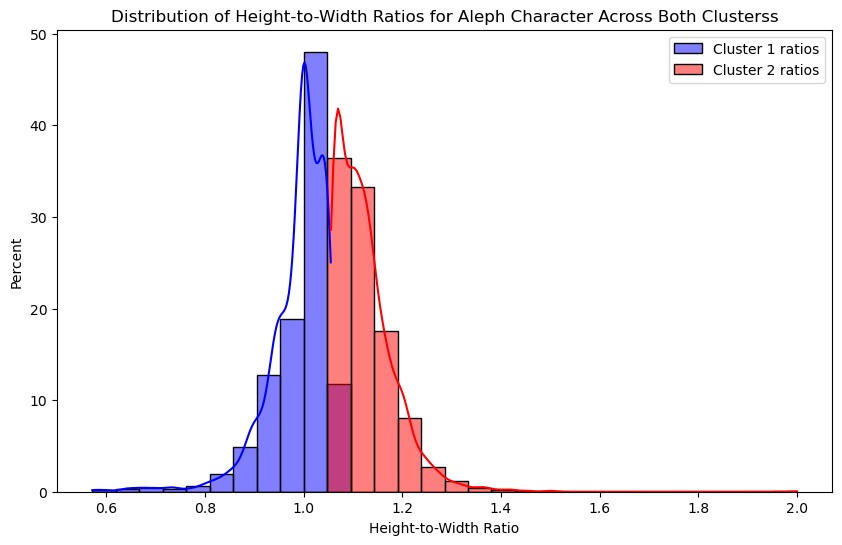

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cluster1_ratios = []
[cluster1_ratios.extend(ratios) for ratios in cluster1.values()]

cluster2_ratios = []
[cluster2_ratios.extend(ratios) for ratios in cluster2.values()]

# Calculate bin edges 
combined_data = np.concatenate([cluster1_ratios, cluster2_ratios])
bin_edges = np.histogram_bin_edges(combined_data, bins=30)

# Plot histograms with aligned bins
plt.figure(figsize=(10, 6))
sns.histplot(cluster1_ratios, bins=bin_edges, color='blue', alpha=0.5, kde=True, stat="percent", label='Cluster 1 ratios')
sns.histplot(cluster2_ratios, bins=bin_edges, color='red', alpha=0.5, kde=True, stat="percent", label='Cluster 2 ratios')
plt.title('Distribution of Height-to-Width Ratios for Aleph Character Across Both Clusters')
plt.ylabel('Percent')
plt.xlabel('Height-to-Width Ratio')
plt.legend()
plt.savefig("figures/cluster/distribution_aleph_clusters.jpg", format="jpg", dpi=600)
plt.show()



Now we turn to after clustering:

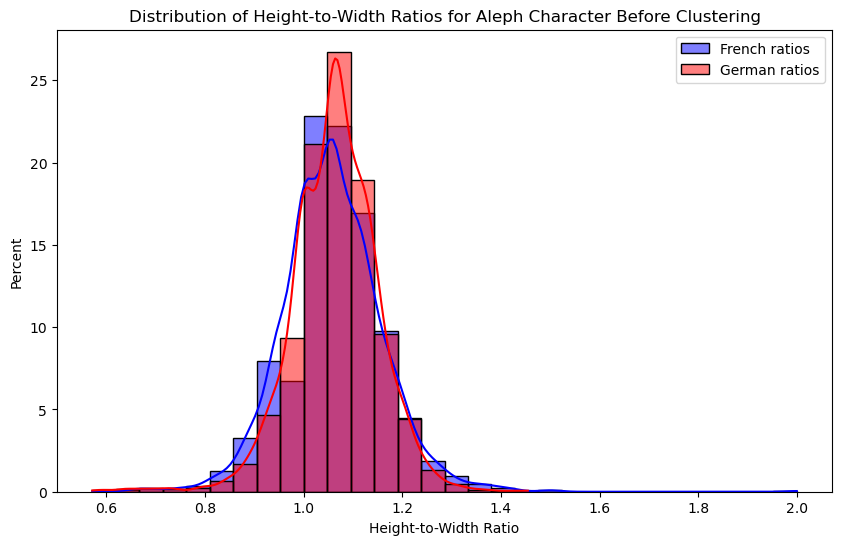

In [18]:
ratios_french = []
[ratios_french.extend(ratios) for ratios in ratios_per_manuscript_french.values()]

ratios_german = []
[ratios_german.extend(ratios) for ratios in ratios_per_manuscript_german.values()]

# Calculate bin edges 
combined_data = np.concatenate([ratios_french, ratios_german])
bin_edges = np.histogram_bin_edges(combined_data, bins=30)

# Plot histograms with aligned bins
plt.figure(figsize=(10, 6))
sns.histplot(ratios_french, bins=bin_edges, color='blue', alpha=0.5, kde=True, stat="percent", label='French ratios')
sns.histplot(ratios_german, bins=bin_edges, color='red', alpha=0.5, kde=True, stat="percent", label='German ratios')
plt.title('Distribution of Height-to-Width Ratios for Aleph Character Before Clustering')
plt.ylabel('Percent')
plt.xlabel('Height-to-Width Ratio')
plt.legend()
plt.savefig("figures/cluster/distribution_aleph.jpg", format="jpg", dpi=600)
plt.show()

